**Assignment4, PartB:** Implement a large deformation example and demonstrate both h and p mesh refinement studies.

I decieded to use the example in part A, but apply bigger forces to achieve large displacements. A 2D rectangular beam is fixed at one end and a distributed force is applied to that beam. I look at the displacement at the tip of the structure and calculate relative absolute error(%) compared to the dispalcement of the finest mesh for both h and p refinements.

Problem: I used the 2D linear elasticity problem. The parameters are taken from [here](https://comet-fenics.readthedocs.io/en/latest/demo/elasticity/2D_elasticity.py.html). The following tutorial is taken from [this link](https://bleyerj.github.io/comet-fenicsx/intro/linear_elasticity/linear_elasticity.html). ChatGPT was used in commenting, getting the correct notations and writing fucntions.

**Importing Modules**

In [1]:
import numpy as np                              # Numerical operations
import matplotlib.pyplot as plt                  # Plotting library
import logging                                   # For logging progress messages
from ufl import sym, grad, Identity, tr, inner, Measure, TestFunction, TrialFunction  # UFL for FEM formulation
from mpi4py import MPI                           # MPI for parallel computing
from dolfinx import fem                          # DOLFINx FEM tools
import dolfinx.fem.petsc                         # PETSc linear solver interface
from dolfinx.mesh import create_rectangle, CellType  # Mesh generation tools

**Defining Functions**

Error : 100 ( tip_displacement - tip_displaceemnt_of_finest_mesh) / tip_displaceemnt_of_finest_mesh

In [2]:
# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(message)s')  # Configure logging format and level

# --- Core Functions ---

# Function to generate a rectangular mesh domain
def generate_rectangle_domain(length, height, Nx, Ny, cell_type):
    return create_rectangle(MPI.COMM_WORLD, [np.array([0, 0]), np.array([length, height])], [Nx, Ny], cell_type=cell_type)

# Function to define function space and displacement function
def set_function_space(domain, degree):
    dim = domain.topology.dim                         # Get dimension of the domain (2D here)
    shape = (dim,)                                    # Vector field shape (displacement vector)
    V = fem.functionspace(domain, ("P", degree, shape))  # Define vector function space of degree 'degree'
    u_sol = fem.Function(V, name="Displacement")      # Initialize displacement function
    return V, u_sol, dim

# Function to define material properties (Lamé parameters)
def define_material_properties(domain, E_value, nu_value):
    E = fem.Constant(domain, E_value)                 # Young's modulus as constant
    nu = fem.Constant(domain, nu_value)               # Poisson's ratio as constant
    lmbda = E * nu / (1 + nu) / (1 - 2 * nu)          # First Lamé parameter
    mu = E / 2 / (1 + nu)                             # Second Lamé parameter (shear modulus)
    return E, nu, lmbda, mu

# Define strain tensor (ε)
def epsilon(v): 
    return sym(grad(v))                               # Symmetric gradient of displacement

# Define stress tensor (σ) using Hooke's law for isotropic material
def sigma(v, lmbda, mu, dim): 
    return lmbda * tr(epsilon(v)) * Identity(dim) + 2 * mu * epsilon(v)

# Define weak form (variational problem)
def define_variational_problem(V, domain, lmbda, mu, rho, g, dim):
    u = TrialFunction(V)                              # Trial function (unknown displacement)
    v = TestFunction(V)                               # Test function
    f = fem.Constant(domain, np.array([0, -rho * g])) # Body force vector (gravity)
    dx = Measure("dx", domain=domain)                 # Integration measure
    a = inner(sigma(u, lmbda, mu, dim), epsilon(v)) * dx  # Bilinear form
    L = inner(f, v) * dx                              # Linear form
    return a, L

# Apply Dirichlet BC: Fix left edge (u = 0)
def apply_boundary_conditions(V):
    left = lambda x: np.isclose(x[0], 0.0)            # Define left boundary condition (x = 0)
    left_dofs = fem.locate_dofs_geometrical(V, left)  # Locate degrees of freedom on left edge
    return [fem.dirichletbc(np.zeros((2,)), left_dofs, V)]  # Apply zero displacement BC

# Solve linear system
def solve_problem(a, L, u_sol, bcs):
    problem = fem.petsc.LinearProblem(a, L, u=u_sol, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})  # Direct solver
    return problem.solve()                             # Solve and return solution

# Extract vertical displacement at the tip (right edge, mid-height)
def extract_tip_displacement(V, uh, length, height):
    V1, dof_map = V.sub(1).collapse()                  # Extract y-component function space
    sub_tip = fem.locate_dofs_geometrical(V1, lambda x: np.isclose(x[0], length) & np.isclose(x[1], height/2))  # Locate tip DOF
    global_tip = dof_map[sub_tip[0]]                   # Map to global DOF index
    return uh.x.array[global_tip]                      # Return displacement value at tip

# --- Run h-refinement for multiple degrees with Logging ---
def run_h_refinement_multiple_degrees(mesh_sizes, degrees, params):
    results = {}                                       # Dictionary to store displacements per degree
    for deg in degrees:                                # Loop over polynomial degrees
        tip_displacements = []                         # List to store displacements for current degree
        for Nx, Ny in mesh_sizes:                      # Loop over mesh sizes
            logging.info(f"Running mesh [{Nx}x{Ny}], degree [{deg}]...")  # Log start
            domain = generate_rectangle_domain(params['length'], params['height'], Nx, Ny, params['cell_type'])  # Generate mesh
            V, u_sol, dim = set_function_space(domain, deg)   # Define function space
            E, nu, lmbda, mu = define_material_properties(domain, params['E_value'], params['nu_value'])  # Material props
            a, L = define_variational_problem(V, domain, lmbda, mu, params['rho'], params['g'], dim)  # Weak form
            bcs = apply_boundary_conditions(V)         # Apply BCs
            uh = solve_problem(a, L, u_sol, bcs)       # Solve FEM problem
            tip_disp = extract_tip_displacement(V, uh, params['length'], params['height'])  # Get tip displacement
            tip_displacements.append(tip_disp)         # Store result
            logging.info(f"Done with mesh [{Nx}x{Ny}], degree [{deg}]\n")  # Log completion
        results[deg] = tip_displacements               # Store results for this degree
    return results

# --- Plotting Function ---
def plot_multiple_degrees(mesh_sizes, results, filename_prefix):
    x = list(range(len(mesh_sizes)))                   # X-axis indices
    xticks_labels = [f"{Nx}x{Ny}" for Nx, Ny in mesh_sizes]  # X-tick labels showing mesh sizes

    # Plot Tip Displacement vs Mesh Size
    plt.figure()
    for deg, disps in results.items():                 # Plot each degree's results
        plt.plot(x, disps, marker='o', label=f"Degree {deg}")
    plt.xticks(x, xticks_labels)
    plt.xlabel("Mesh Size (Nx x Ny)")
    plt.ylabel("Tip Displacement")
    plt.title("Tip Displacement vs Mesh Size")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{filename_prefix}_tip_displacement.png")  # Save plot

    # Plot Absolute Percent Relative Error vs Mesh Size
    plt.figure()
    for deg, disps in results.items():
        ref_disp = disps[-1]   # Use the displacement from the finest mesh as reference
        percent_errors = [abs((d - ref_disp) / ref_disp) * 100 for d in disps]  # Percent relative error
        plt.plot(x, percent_errors, marker='o', label=f"Degree {deg}")
    plt.xticks(x, xticks_labels)
    plt.xlabel("Mesh Size (Nx x Ny)")
    plt.ylabel("Percent Relative Error (%)")
    plt.title("Percent Relative Error vs Mesh Size")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{filename_prefix}_percent_relative_error.png")  # Save plot


**Main Execution**

In [3]:
logging.info("Starting h-refinement analysis...\n")    # Log start of process

# Define problem parameters
params = {
    'length': 25.0,                                    # Beam length
    'height': 1.0,                                     # Beam height
    'cell_type': CellType.quadrilateral,               # Mesh cell type
    'E_value': 1e5,                                    # Young's modulus
    'nu_value': 0.3,                                   # Poisson's ratio
    'rho': 1 / 9.81,                                   # Density (inverse of g for unit load)
    'g': 9.81                                          # Gravity acceleration
}

# Define mesh sizes and polynomial degrees to test
mesh_sizes = [(10, 2), (20, 4), (40, 8), (80, 16), (160, 32)]  # List of mesh refinements
degrees = [1, 2, 3]                                             # List of polynomial degrees

# Run simulations
results = run_h_refinement_multiple_degrees(mesh_sizes, degrees, params)

logging.info("All simulations completed.")  # Log after solving


Starting h-refinement analysis...

Running mesh [10x2], degree [1]...
/projectnb/me700/students/sjazad/.conda/envs/hw4-env/lib/python3.13/site-packages/dolfinx/mesh.py:867: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  msh = _cpp.mesh.create_rectangle_float64(comm, points, n, cell_type, partitioner, diagonal)

/projectnb/me700/students/sjazad/.conda/envs/hw4-env/lib/python3.13/site-packages/dolfinx/fem/function.py:630: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  cpp_dofmap = _cpp.fem.create_dofmap(mesh.comm, mesh.topology._cpp_object, cpp_element)

/projectnb/me700/students/sjazad/.conda/envs/hw4-env/lib/python3.13/site-packages/dolfinx/la.py:367: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  return PETSc.Vec().createG

**Plots**

Plots saved. Process finished.


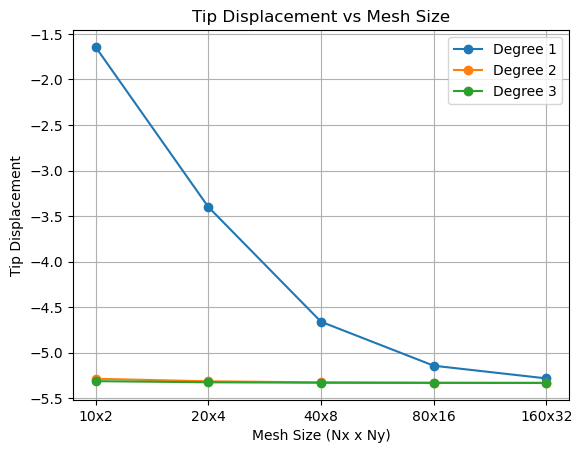

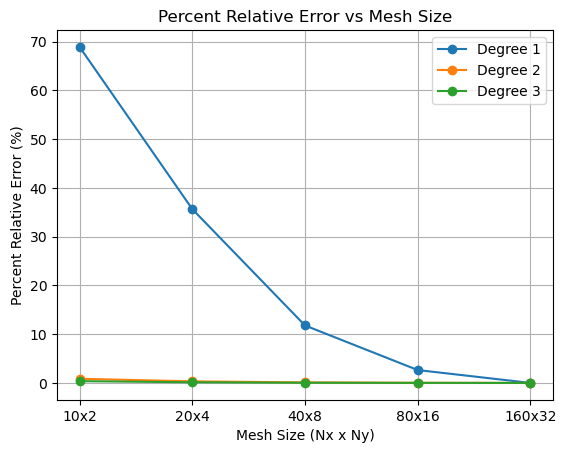

In [4]:
# Plot results
plot_multiple_degrees(mesh_sizes, results, "h_ref_multiple_degrees")

logging.info("Plots saved. Process finished.")                   # Final log message